In [28]:
import os
import re 
import pandas as pd
import seaborn as sns 
import numpy as np 

pointMiniGames = "Sammelwahn, Schießstand, Walls, Mini Survivalgames, Mini Skywars, Lasertag, Minengefecht, Einer im Köcher, Paintball, Spleef, Buntes Chaos, Reihenfolge, Duelle" 
timeMiniGames = "Wettrennen, Jump and Run, Pferderennen, Drachenflucht, Replika, Blockhüpfer, Todeswürfel, Freier Fall, Elytrarennen, Waffenfolge, Minenfeld, Kletter-König, Ampelrennen, Hoch hinaus"

miniGameList = ["1-Sammelwahn",
        "2-Schießstand",
        "3-Wettrennen",
        "4-Pferderennen",
        "5-Drachenflucht",
        "6-Jump and Run",
        "7-Hoch Hinaus",
        "8-Blockhüpfer",
        "9-Todeswürfel",
        "10-Freier Fall",
        "11-Elytrarennen",
        "12-Waffenfolge",
        "13-Minenfeld",
        "14-Kletterkönig",
        "15-Ampelrennen",
        "16-Replika",
        "17-Walls",
        "18-Mini SG",
        "19-Mini SW",
        "20-Lasertag",
        "21-Minengefecht",
        "22-OITC",
        "23-Paintball",
        "24-Spleef",
        "25-Buntes Chaos",
        "26-Reihenfolge",
        "27-Duelle"]

def getPlayerPaths():
    file_list = os.listdir('in-new')
    return file_list

def read_file(file):
    with open('in-new/'+file, 'r') as f:
        data = f.read().replace('TooltipEvent, ', '')
    return data

def getRecordData(playerPath, minigame):
    data = read_file(playerPath).split('\n')
    for line in data: 
        if minigame in line: 
            minigameData = line
            minigameData = minigameData.replace(minigame, '').strip()
            return minigameData  # return the data instead of printing it

def create_dataframe(input_string, minigame):

    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(?:(\d+)\s*min\s*)?(?:(\d+)\s*s\s*)?(\d+)\s*ms'

    # Find all matches in the input string
    try: matches = re.findall(pattern, input_string)
    except: matches = None

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    if matches: 
        for match in matches:
            map_name = match[0]
            minutes = int(match[1] or 0)
            seconds = int(match[2] or 0) + int(match[3]) / 1000
            time_seconds = minutes * 60 + seconds
            data[map_name] = time_seconds
    else: return pd.DataFrame()

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])


    return df


def createPointDataframe(input_string, minigame):
    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(\d+)'

    # Find all matches in the input string
    matches = re.findall(pattern, input_string)

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    for match in matches:
        map_name = match[0]
        time_value = int(match[1])
        data[map_name] = time_value

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])
    return df.fillna(0)


paths = getPlayerPaths()

def getRecordsDataframe(minigame='Wettrennen', save=False, log=False, html=False):
    outDf = pd.DataFrame()

    if log:
        print(f'processing {minigame}...')

    if minigame in pointMiniGames: 
        pass
    elif minigame in timeMiniGames:
        pass
    else: 
        ValueError('Not a valid minigame name')

    for i in paths:
        if minigame in timeMiniGames:
            df = create_dataframe(getRecordData(playerPath=i, minigame=minigame), minigame)
        if minigame in pointMiniGames:
            try: 
                df = createPointDataframe(getRecordData(playerPath=i, minigame=minigame), minigame)
                df.fillna(0, inplace=True)
            except: 
                continue

        if df is not None:  
            df.index = [i.replace('.txt', '')]
            outDf = pd.concat([outDf, df])

    outPath = 'out/' + minigame + '.json'

    '''
        Minigame Specific changes to the df
    '''

    if ("Replika" in minigame): 

        replikaDf = outDf 
        replikaDf.fillna(25, inplace=True) # assigning a value to a never-played-before pattern, 17 perturbs worse player order and alt account stats lol, 27 is probably too much, difficult to choose an appropriate value here
        row_sums = replikaDf.sum(axis=1)
        
        # Append the sum as a new column
        replikaDf['Sum'] = row_sums

        # Re-indexing
        replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)
    
        # Move 'Sum' column to the first position
        cols = replikaDf.columns.tolist()
        cols = ['Sum'] + [col for col in cols if col != 'Sum']
        replikaDf = replikaDf[cols]

        # Removing player data with too many NaNs (players that haven't played most of the patterns)
        # replikaDf = replikaDf.drop(columns=["Ritokii", "Feinberg", "Sebi1801"])

        outDf = replikaDf

    if ("Sammelwahn" in minigame):

        row_sums = outDf.sum(axis=1)

        # Append the sum as a new column
        outDf['Sum'] = row_sums

        # Re-indexing
        outDf = outDf.reindex(sorted(outDf.columns), axis=1)

        # Move 'Sum' column to the first position
        cols = outDf.columns.tolist()
        cols = ['Sum'] + [col for col in cols if col != 'Sum']
        outDf = outDf[cols]

    if ("Lasertag" in minigame):
        # Merge the columns "tungen Port" and "Port" into one column
        
        # debug 
        # print(outDf.columns)

        outDf["Tötungen Port"] = outDf["Tötungen Port"].replace(0, np.nan)
        outDf["tungen Port"] = outDf["tungen Port"].replace(0, np.nan)

        outDf["temp1"] = outDf["Tötungen Port"].fillna(outDf["tungen Port"])
        try: outDf.drop(columns=["Port"], inplace=True)
        except: pass
        outDf["Port"] = outDf["temp1"]

        outDf["Tötungen Neon"] = outDf["Tötungen Neon"].replace(0, np.nan)
        outDf["tungen Neon"] = outDf["tungen Neon"].replace(0, np.nan)

        outDf["temp2"] = outDf["Tötungen Neon"].fillna(outDf["tungen Neon"])
        try: outDf.drop(columns=["Neon"], inplace=True)
        except: pass
        outDf["Neon"] = outDf["temp2"]

        outDf.drop(columns=["temp1", "temp2", "tungen Neon", "Tötungen Neon", "tungen Port", "Tötungen Port"], inplace=True)
        

    if ("Einer im Köcher" in minigame):
        outDf["Tötungen Asia"] = outDf["Tötungen Asia"].replace(0, np.nan)
        outDf["Asia"] = outDf["Asia"].replace(0, np.nan)

        outDf["temp1"] = outDf["Asia"].fillna(outDf["Tötungen Asia"])
        try: outDf.drop(columns=["Asia", "Tötungen Asia"], inplace=True)
        except: pass
        outDf["Asia"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)
        
    if ("Paintball" in minigame):
        outDf["Tötungen Arabic"] = outDf["Tötungen Arabic"].replace(0, np.nan)
        outDf["tungen Arabic"] = outDf["tungen Arabic"].replace(0, np.nan)

        outDf["temp1"] = outDf["tungen Arabic"].fillna(outDf["Tötungen Arabic"])
        try: outDf.drop(columns=["tungen Arabic", "Tötungen Arabic"], inplace=True)
        except: pass
        outDf["Arabic"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)

        # SW Columns: Swamp', 'Tötung Asia', 'Tötungen Asia', 'Tötungen Coconut', 'Wild West', 'tung Asia', 'tungen Asia'

    if ("Mini Skywars" in minigame):
        outDf["Tötungen Asia"] = outDf["Tötungen Asia"].replace(0, np.nan)
        outDf["Tötung Asia"] = outDf["Tötung Asia"].replace(0, np.nan)
        #outDf["tung Asia"] = outDf["tung Asia"].replace(0, np.nan)
        outDf["tungen Asia"] = outDf["tungen Asia"].replace(0, np.nan)

        outDf["temp1"] = outDf["Tötungen Asia"].fillna(outDf["Tötung Asia"])
        #outDf["temp1"] = outDf["Tötungen Asia"].fillna(outDf["tung Asia"])
        outDf["temp1"] = outDf["Tötungen Asia"].fillna(outDf["tungen Asia"])
        try: outDf.drop(columns=["Tötung Asia", "Tötungen Asia", 'tungen Asia'], inplace=True)
        except: pass
        outDf["Asia"] = outDf["temp1"]

        outDf["Tötungen Coconut"] = outDf["Tötungen Coconut"].replace(0, np.nan)
        #outDf["tungen Coconut"] = outDf["tungen Coconut"].replace(0, np.nan)

        #outDf["temp2"] = outDf["tungen Coconut"].fillna(outDf["Tötungen Coconut"])
        try: outDf.drop(columns=["tungen Coconut", "Tötungen Coconut"], inplace=True)
        except: pass
        #outDf["Coconut"] = outDf["temp2"]

        outDf.drop(columns=["temp1"], inplace=True)

    if ("Minengefecht" in minigame):
        outDf["Tötungen Overworld"] = outDf["Tötungen Overworld"].replace(0, np.nan)
        outDf["Overworld"] = outDf["Overworld"].replace(0, np.nan)
        outDf["tungen Overworld"] = outDf["tungen Overworld"].replace(0, np.nan)

        outDf["temp1"] = outDf["Overworld"].fillna(outDf["Tötungen Overworld"])
        outDf["temp1"] = outDf["temp1"].fillna(outDf["tungen Overworld"])

        try: outDf.drop(columns=["Overworld", "tungen Overworld", "Tötungen Overworld"], inplace=True)
        except: pass
        outDf["Overworld"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)
        
        outDf["Tötungen Ruin"] = outDf["Tötungen Ruin"].replace(0, np.nan)
        outDf["tungen Ruin"] = outDf["tungen Ruin"].replace(0, np.nan)

        outDf["temp2"] = outDf["tungen Ruin"].fillna(outDf["Tötungen Ruin"])
        try: outDf.drop(columns=["tungen Ruin", "Tötungen Ruin"], inplace=True)
        except: pass
        outDf["Ruin"] = outDf["temp2"]

        outDf.drop(columns=["temp2"], inplace=True)

    if ("Spleef" in minigame):
        outDf["Tötungen Mountains"] = outDf["Tötungen Mountains"].replace(0, np.nan)
        outDf["Mountains"] = outDf["Mountains"].replace(0, np.nan)
        outDf["tungen Mountains"] = outDf["tungen Mountains"].replace(0, np.nan)

        outDf["temp1"] = outDf["Mountains"].fillna(outDf["Tötungen Mountains"])
        outDf["temp1"] = outDf["temp1"].fillna(outDf["tungen Mountains"])

        try: outDf.drop(columns=["Mountains", "tungen Mountains", "Tötungen Mountains"], inplace=True)
        except: pass
        outDf["Mountains"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)

    if ("Walls" in minigame): 
        outDf["Tötungen Grass"] = outDf["Tötungen Grass"].replace(0, np.nan)
        outDf["Grass"] = outDf["Grass"].replace(0, np.nan)
        outDf["tungen Grass"] = outDf["tungen Grass"].replace(0, np.nan)
        outDf["Tötung Grass"] = outDf["Tötung Grass"].replace(0, np.nan)

        outDf["temp1"] = outDf["Grass"].fillna(outDf["Tötungen Grass"])
        outDf["temp1"] = outDf["temp1"].fillna(outDf["tungen Grass"])
        outDf["temp1"] = outDf["temp1"].fillna(outDf["Tötung Grass"])

        try: outDf.drop(columns=["Grass", "tungen Grass", "Tötungen Grass", "Tötung Grass"], inplace=True)
        except: pass

        outDf["Grass"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)
        
        outDf["Tötungen Vulcano"] = outDf["Tötungen Vulcano"].replace(0, np.nan)
        outDf["tungen Vulcano"] = outDf["tungen Vulcano"].replace(0, np.nan)

        outDf["temp2"] = outDf["tungen Vulcano"].fillna(outDf["Tötungen Vulcano"])
        try: outDf.drop(columns=["tungen Vulcano", "Tötungen Vulcano"], inplace=True)
        except: pass
        outDf["Vulcano"] = outDf["temp2"]

        outDf.drop(columns=["temp2"], inplace=True)
        

    # Sorting columns alphabetically for any outDf except if minigame == "Replika" (sum column)
    
    if ("Replika" not in minigame):
        if ("Sammelwahn" not in minigame):
            outDf = outDf.reindex(sorted(outDf.columns), axis=1)


    '''
        debugging options and html export for figure generation
    '''
        
    if save: 
        if "Replika" in minigame: 
            json_df = outDf.iloc[:, 1:]
            json_df.T.to_json(outPath)
        
        else: outDf.T.to_json(outPath) 


    if html: 
        log = False 
        html_table = ""
        if ("Drache" in minigame) or ("Mini" in minigame) or ("Köcher" in minigame) or ("Lasertag" in minigame) or ("Minengef" in minigame) or ("Paint" in minigame) or ("Reihenf" in minigame) or ("Sammel" in minigame) or ("Schießs" in minigame) or ("Spleef" in minigame) or ("Walls" in minigame): 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('<td>NaN</td>', '<td>0</td>').replace('.0</td>', '</td>').replace('Tötungen Asia', 'Asia').replace('Tötungen', '').replace('Punkte', '')
        elif ("Pferde" in minigame):
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('>9', '>09').replace('>8', '>08').replace('>7', '>07').replace('>6', '>06').replace('>5', '>05').replace('>4', '>04').replace('s Arena', "Wario's Arena").replace('>Cheep B', ">Cheep Cheep B")
        elif ("Replika" in minigame): 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('>9.', '>09.').replace('>8.', '>08.').replace('>7.', '>07.').replace('>6.', '>06.').replace('>5.', '>05.').replace('>4.', '>04.').replace('>3.', '>03.').replace('>ms ','>').replace('>30.000','>None')
        else: 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('Punkte', '').replace('Runden', '').replace('Blossom', 'Cherry Blossom')
        
        print(html_table)

    if log: 
        print(f'{minigame} processed and saved to {outPath}')

    if html == False: 
        return outDf


# HTML assembly #

frontWrapperList = []
x = 0
endWrapper = "</table> </div>"

for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')):
    x = x + 1
    strX = str(x)
    frontWrapperList.append('<!-- Table: ' + i + ' --> <div id="table' + strX + '" style="display:none;"> <table id="dataframe' + strX + '" class="display nowrap">')

print('<div class="table-container">')
x = 0
for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')):
    print(frontWrapperList[x])
    getRecordsDataframe(minigame=i, save=True, log=False, html=True)
    print(endWrapper)
    x = x + 1
print('</div>')

<div class="table-container">
<!-- Table: Ampelrennen --> <div id="table1" style="display:none;"> <table id="dataframe1" class="display nowrap">
  <thead>    <tr style="text-align: right;">      <th></th>      <th>Castle</th>      <th>Street</th>    </tr>  </thead>  <tbody>    <tr>      <th>20LeRe10</th>      <td>20.866</td>      <td>22.760</td>    </tr>    <tr>      <th>agowskyy</th>      <td>22.290</td>      <td>23.965</td>    </tr>    <tr>      <th>Allooy</th>      <td>22.131</td>      <td>25.048</td>    </tr>    <tr>      <th>Anni808</th>      <td>19.416</td>      <td>23.351</td>    </tr>    <tr>      <th>Axollotel</th>      <td>21.213</td>      <td>23.867</td>    </tr>    <tr>      <th>BacardiSprite</th>      <td>21.393</td>      <td>25.406</td>    </tr>    <tr>      <th>bawskey</th>      <td>21.987</td>      <td>23.858</td>    </tr>    <tr>      <th>BusinessBent</th>      <td>22.069</td>      <td>24.759</td>    </tr>    <tr>      <th>ByNetherdude</th>      <td>21.683</td>      <t

In [29]:
type(str(getRecordsDataframe(minigame='Drachenflucht', save=False, log=False, html=True)))

  <thead>    <tr style="text-align: right;">      <th></th>      <th>Ancient City</th>      <th>Chaotic Cubes</th>      <th>Factory</th>      <th>Hills</th>      <th>Temple</th>    </tr>  </thead>  <tbody>    <tr>      <th>20LeRe10</th>      <td>116.878</td>      <td>67.774</td>      <td>155.244</td>      <td>157.494</td>      <td>158.576</td>    </tr>    <tr>      <th>agowskyy</th>      <td>0</td>      <td>0</td>      <td>150.111</td>      <td>155.663</td>      <td>155.536</td>    </tr>    <tr>      <th>Allooy</th>      <td>116.297</td>      <td>79.298</td>      <td>150.983</td>      <td>150.406</td>      <td>157.427</td>    </tr>    <tr>      <th>Anni808</th>      <td>118.877</td>      <td>0</td>      <td>155.106</td>      <td>155.245</td>      <td>157.144</td>    </tr>    <tr>      <th>Axollotel</th>      <td>0</td>      <td>0</td>      <td>147.436</td>      <td>155.294</td>      <td>153.277</td>    </tr>    <tr>      <th>BacardiSprite</th>      <td>0</td>      <td>0</td>      <td>1

str

In [30]:
getRecordsDataframe(minigame="Mini Skywars", save=True, log=False, html=False).columns

Index(['Asia', 'Swamp', 'Tötungen Coconut', 'Wild West'], dtype='object')

In [31]:
for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')): print(i)


Ampelrennen
Blockhüpfer
Buntes Chaos
Drachenflucht
Duelle
Einer im Köcher
Elytrarennen
Freier Fall
Hoch hinaus
Jump and Run
Kletter-König
Lasertag
Minenfeld
Minengefecht
Mini Skywars
Mini Survivalgames
Paintball
Pferderennen
Reihenfolge
Replika
Sammelwahn
Schießstand
Spleef
Todeswürfel
Waffenfolge
Walls
Wettrennen


In [32]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True).head(10)

,Sum,Among Us,Apple,Arrow,Baby Yoda,Bee,Blinky,Blue Monster,Cake,Camera,...,ms Arrow,ms Cow,ms Deadpool,ms Doge,ms Sonic,muss los,of Meat,omb,ppHop 1,ppHop 2
Gobo9,1438.491,17.715,13.714,25.0,10.595,9.191,16.549,16.955,17.047,14.511,...,10.428,25.0,25.0,25.0,25.0,16.430,11.513,9.189,16.406,13.471
cediiiiii_10,1654.391,17.443,14.467,25.0,13.400,12.393,17.201,17.361,17.019,17.146,...,12.215,25.0,25.0,25.0,25.0,18.770,13.571,10.306,17.629,14.512
PedroZockt,1665.495,16.777,20.028,25.0,12.779,11.666,17.098,18.044,21.363,17.666,...,12.723,25.0,25.0,25.0,25.0,19.726,14.906,10.340,16.034,15.067
Ex4cted,1702.414,17.440,18.277,25.0,15.045,10.743,17.919,18.328,18.828,16.283,...,11.729,25.0,25.0,25.0,25.0,18.637,12.064,12.806,15.330,16.969
Fflopse,1744.663,20.944,23.413,25.0,16.261,11.767,20.255,17.315,25.708,16.778,...,13.071,25.0,25.0,25.0,25.0,19.538,17.206,12.681,20.650,18.293
KakaMC,1763.950,17.744,19.832,25.0,16.060,11.330,20.464,20.383,19.697,16.829,...,12.255,25.0,25.0,25.0,25.0,28.061,15.932,11.625,17.590,14.525
lizsyy,1813.232,21.085,18.882,25.0,16.566,11.100,18.912,22.717,21.133,17.278,...,13.372,25.0,25.0,25.0,25.0,18.955,14.026,12.599,19.297,15.156
ymq_,1822.191,17.075,18.394,25.0,13.775,10.761,24.772,18.715,21.247,16.482,...,11.056,25.0,25.0,25.0,25.0,20.273,13.879,10.405,22.561,19.838
Grapfen,2002.409,20.709,18.794,25.0,18.238,13.645,22.447,25.407,21.974,18.774,...,13.095,25.0,25.0,25.0,25.0,19.778,17.562,15.487,20.991,18.300
HerrDante,2031.487,23.190,18.364,25.0,19.849,12.656,19.950,21.510,24.873,19.961,...,15.369,25.0,25.0,25.0,25.0,26.236,17.970,10.851,21.257,21.344


In [33]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True)['Sum'].mean()/102 # mean time per pattern for all players

24.4181862745098

In [34]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True)['Sum'].head(10).mean()/102 # mean time per pattern for top 10 players -> this value is used to fill NaN for sum column

17.292865686274514

In [35]:
getRecordData(playerPath=paths[0], minigame='Wettrennen')

'Islands :  1 min  17 s  240 ms Snow :  48 s  046 ms Cyberpunk :  1 min  30 s  740 ms Cherry Blossom Canyon :  1 min  28 s  009 ms Green Hills :  1 min  12 s  907 ms'

In [36]:
for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')): getRecordsDataframe(minigame=i, save=False, log=False, html=True)

  <thead>    <tr style="text-align: right;">      <th></th>      <th>Castle</th>      <th>Street</th>    </tr>  </thead>  <tbody>    <tr>      <th>20LeRe10</th>      <td>20.866</td>      <td>22.760</td>    </tr>    <tr>      <th>agowskyy</th>      <td>22.290</td>      <td>23.965</td>    </tr>    <tr>      <th>Allooy</th>      <td>22.131</td>      <td>25.048</td>    </tr>    <tr>      <th>Anni808</th>      <td>19.416</td>      <td>23.351</td>    </tr>    <tr>      <th>Axollotel</th>      <td>21.213</td>      <td>23.867</td>    </tr>    <tr>      <th>BacardiSprite</th>      <td>21.393</td>      <td>25.406</td>    </tr>    <tr>      <th>bawskey</th>      <td>21.987</td>      <td>23.858</td>    </tr>    <tr>      <th>BusinessBent</th>      <td>22.069</td>      <td>24.759</td>    </tr>    <tr>      <th>ByNetherdude</th>      <td>21.683</td>      <td>24.929</td>    </tr>    <tr>      <th>byTobi</th>      <td>21.094</td>      <td>23.404</td>    </tr>    <tr>      <th>cediiiiii_10</th>      <t

In [37]:
getRecordsDataframe(minigame="Replika", save=False, log=False, html=False).loc['Gobo9']

Sum          1438.491
Among Us       17.715
Apple          13.714
Arrow          25.000
Baby Yoda      10.595
               ...   
muss los       16.430
of Meat        11.513
omb             9.189
ppHop 1        16.406
ppHop 2        13.471
Name: Gobo9, Length: 104, dtype: float64

C:\Users\elias\AppData\Local\Temp\ipykernel_18248\1649410017.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_18248\1649410017.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_18248\1649410017.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_18248\1649410017.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\elias\AppData\Local\Temp\ipykernel_18248\1649410017.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\e

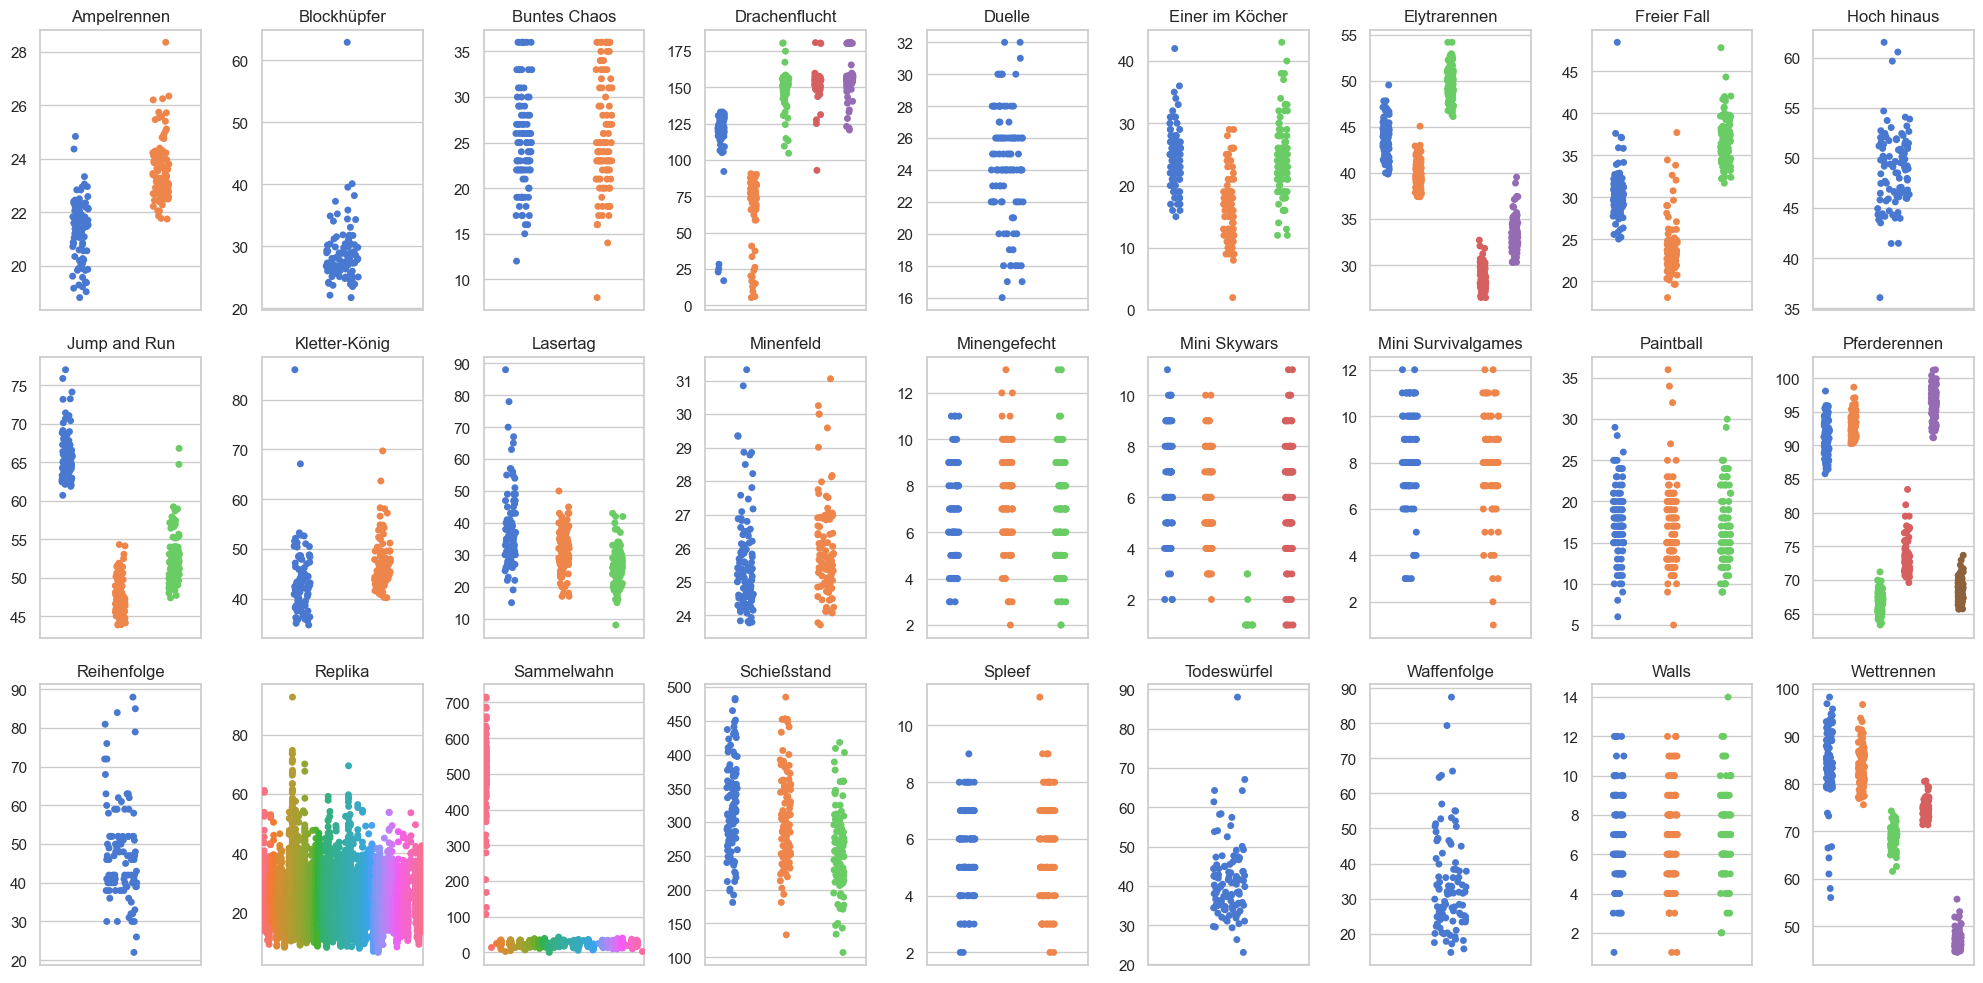

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted")

# List of minigames to plot
minigames = sorted((pointMiniGames + ', ' + timeMiniGames).split(', '))  # Add more minigames as needed

fig, ax = plt.subplots(ncols=9, nrows=3, figsize=[20, 10])

# Flatten the axes array to iterate over it easily
ax = ax.flatten()

def createSmallSwarmPlots():
    # Create swarm plots for each minigame
    for i, minigame in enumerate(minigames):
        data = getRecordsDataframe(minigame=minigame)
        if "Replika" in minigame: 
            data = data.drop(columns=['Sum'])
        sns.stripplot(data=data, ax=ax[i])
        ax[i].set_title(f"{minigame}")
        ax[i].set_ylabel("")

        # Angle x-labels by 45 degrees
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

        # Hide overlapping x-labels
        plt.setp(ax[i].get_xticklabels(), visible=False)
        for label in ax[i].get_xticklabels():
            label.set_visible(False)
            if label.get_text() == '':
                continue
            if ax[i].xaxis.get_major_ticks()[-1].label1.get_window_extent().bounds[2] > ax[i].get_xlim()[1]:
                label.set_visible(False)
            elif label.get_window_extent().bounds[1] < 0:
                label.set_visible(False)

    # Hide any remaining empty subplots
    for i in range(len(minigames), len(ax)):
        ax[i].axis('off')

createSmallSwarmPlots()

plt.tight_layout()
plt.show()


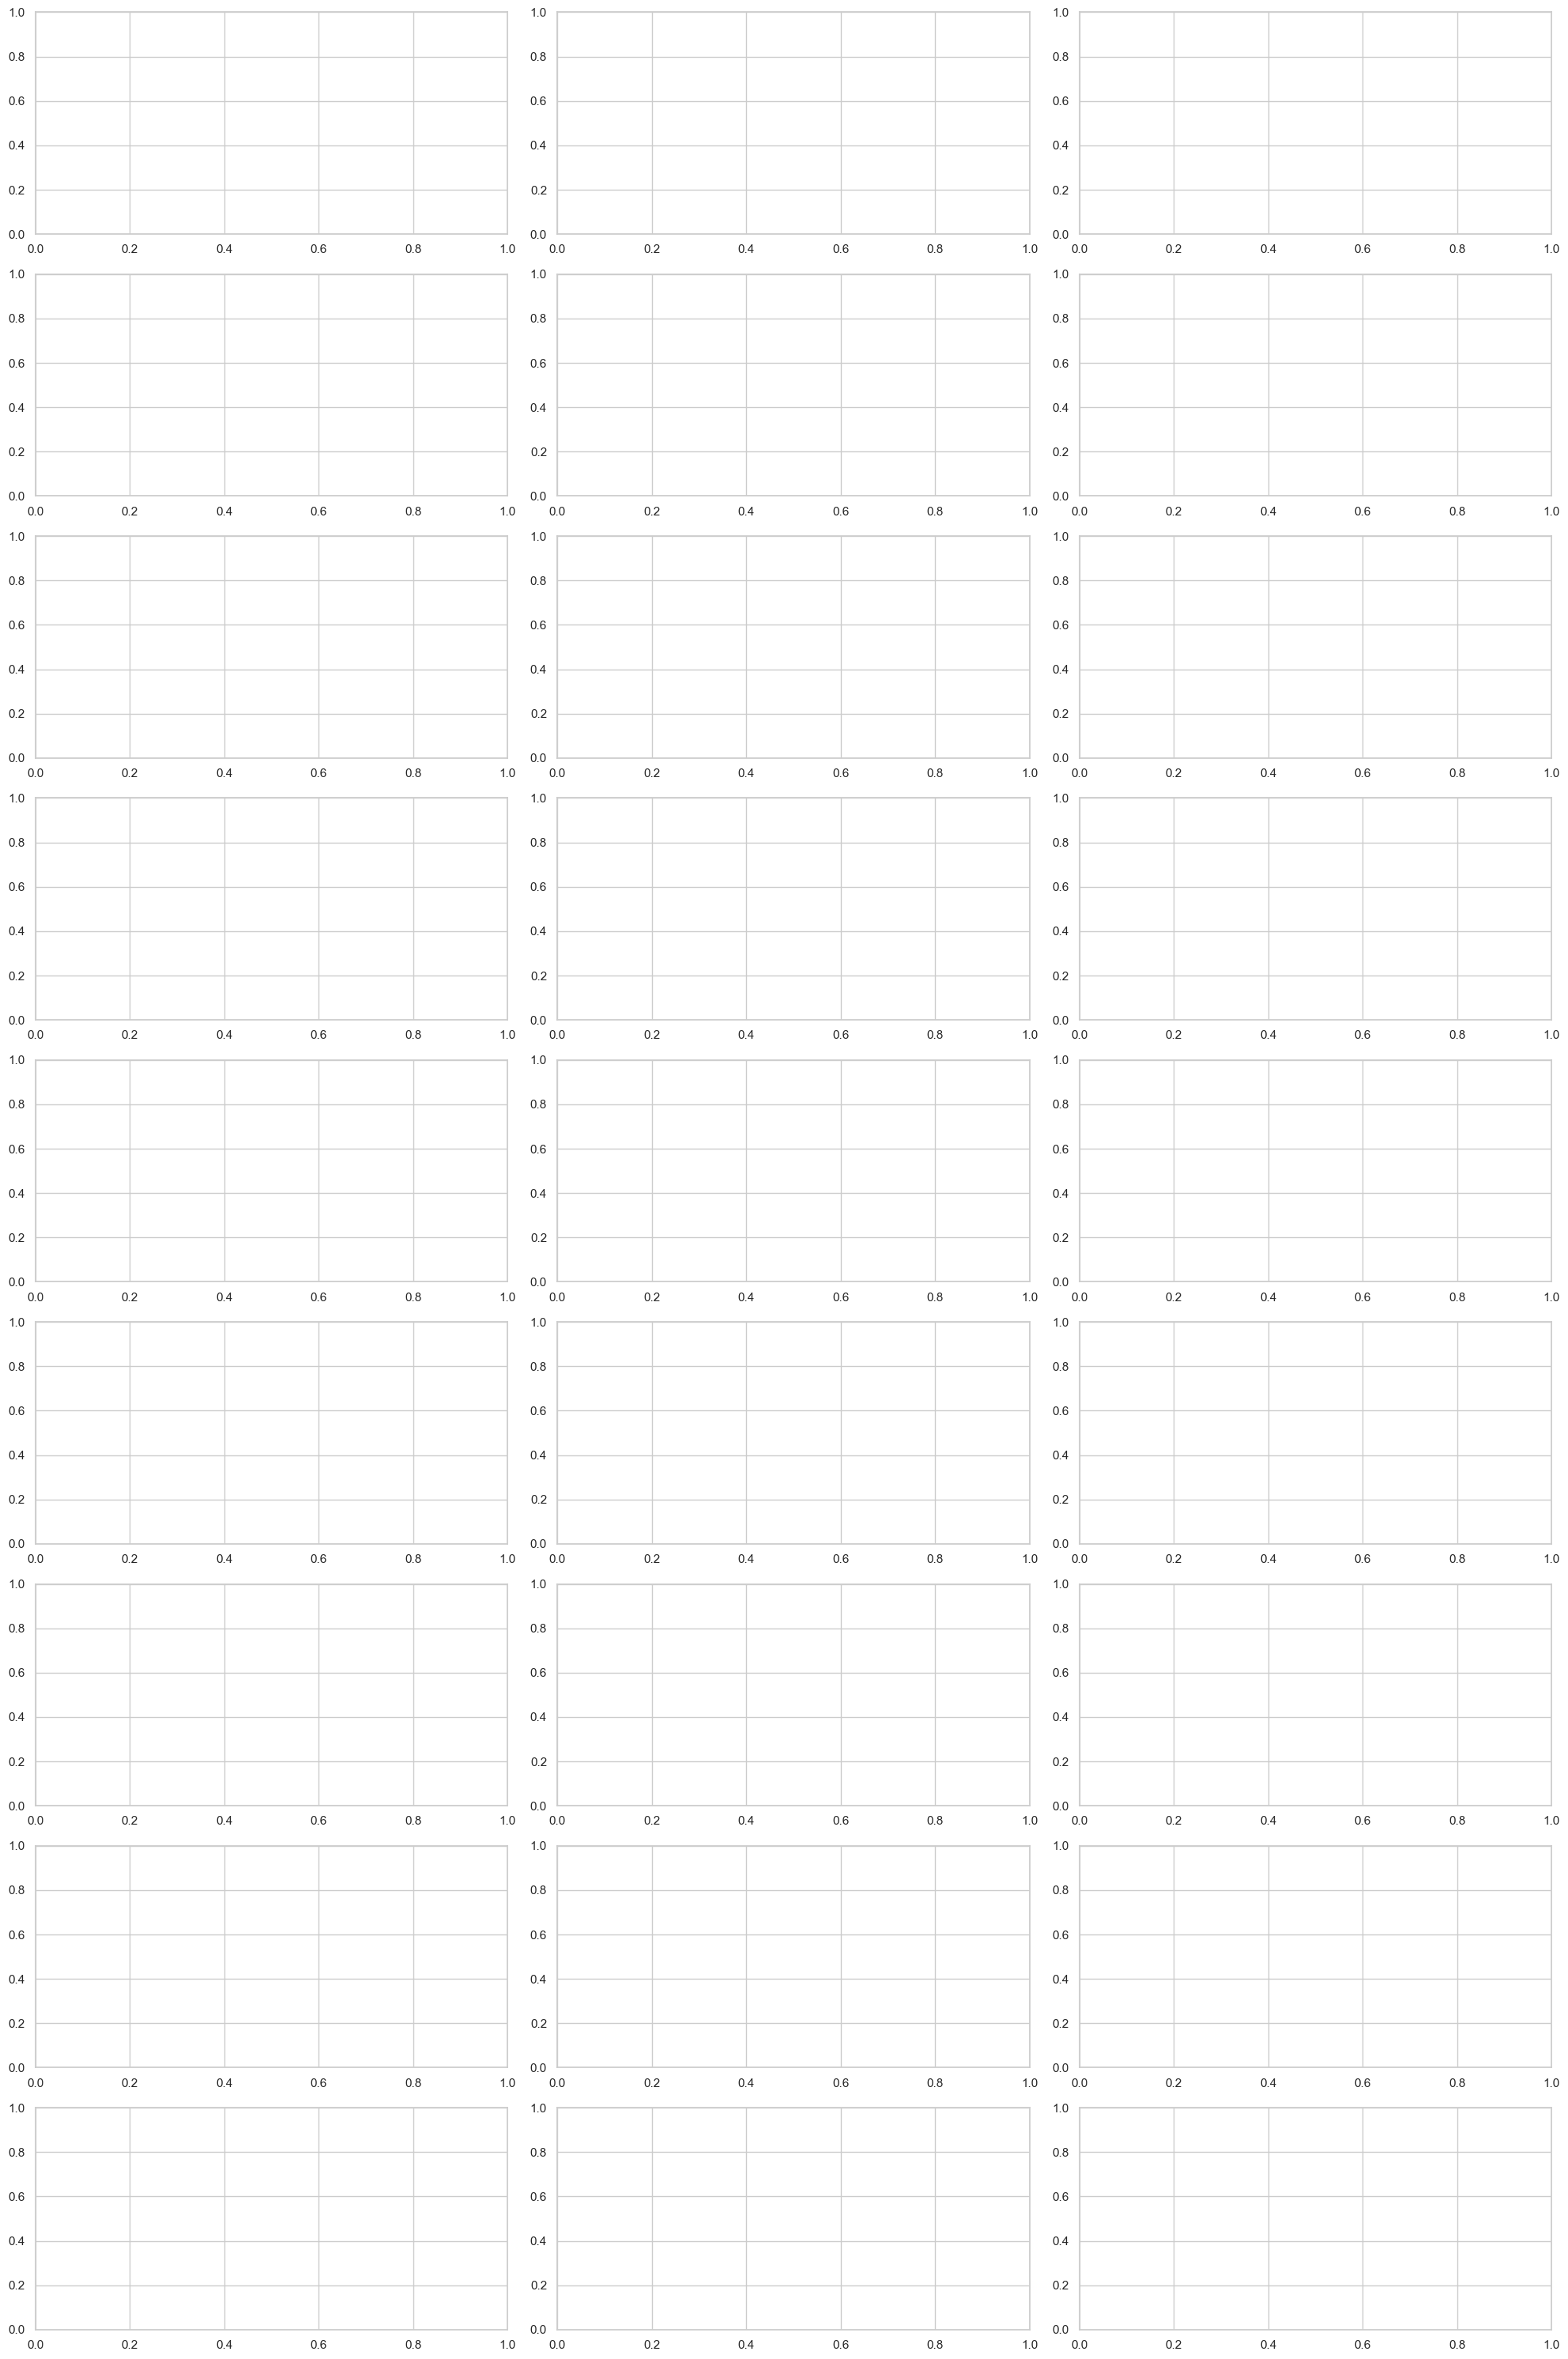

In [39]:
# List of minigames to plot
minigames = sorted((pointMiniGames + ', ' + timeMiniGames).split(', '))  # Add more minigames as needed

fig, ax = plt.subplots(9, 3, figsize=[20, 30])

# Flatten the axes array to iterate over it easily
ax = ax.flatten()

data = getRecordsDataframe(minigame="Replika")
data = data.drop(columns=["ms Cow", "ms Sonic", "Sum"])
replData = data 

# Create swarm plots for each minigame
def createLargeSwarmPlots():
    for i, minigame in enumerate(minigames):
        if "Replika" in minigame: # drop artefact columns for Replika data 
            sns.swarmplot(data=replData, ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")
            ax[i].set_xlabel("")
            ax[i].set_xticks("")
        if "Sammelwahn" in minigame: 
            sns.swarmplot(data=getRecordsDataframe(minigame=minigame), ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")
            ax[i].set_xticks("")
        else:
            sns.swarmplot(data=getRecordsDataframe(minigame=minigame), ax=ax[i])
            ax[i].set_title(f"{minigame}")
            ax[i].set_ylabel("")

    # Hide any remaining empty subplots
    for i in range(len(minigames), len(ax)):
        ax[i].axis('off')

# createLargeSwarmPlots()

plt.tight_layout()
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_18248\1358673855.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



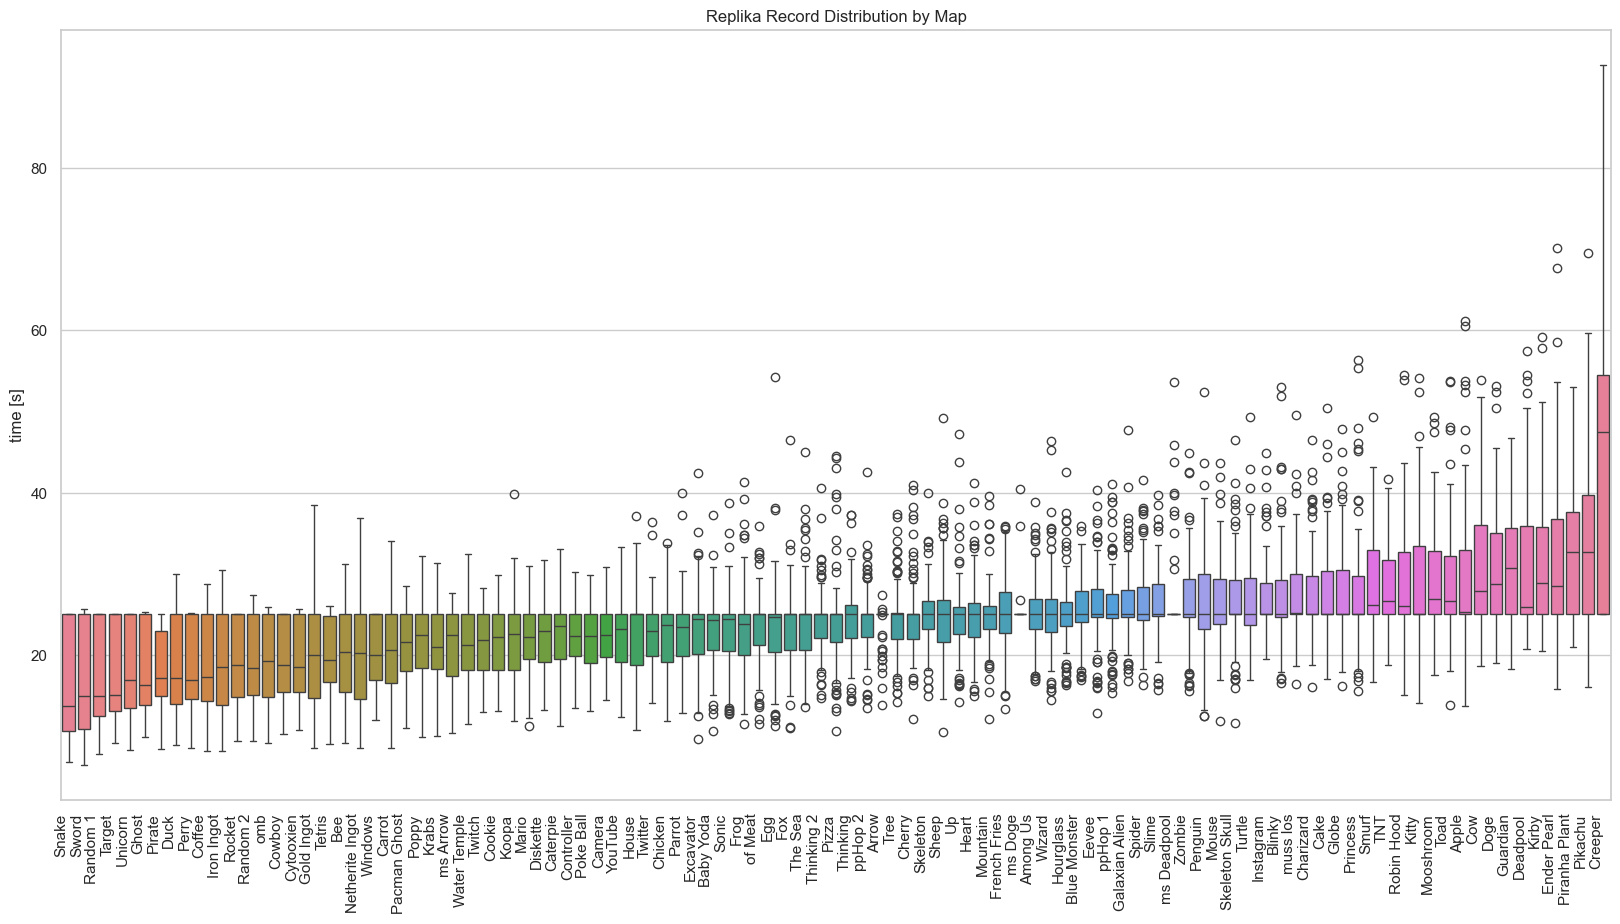

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Replika")

# Drop columns "ms Cow" and "ms Sonic"
data = data.drop(columns=["ms Cow", "ms Sonic", "Sum"])
replData = data 

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.boxplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.title("Replika Record Distribution by Map")
plt.ylabel("time [s]")
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_18248\634766120.py:24: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



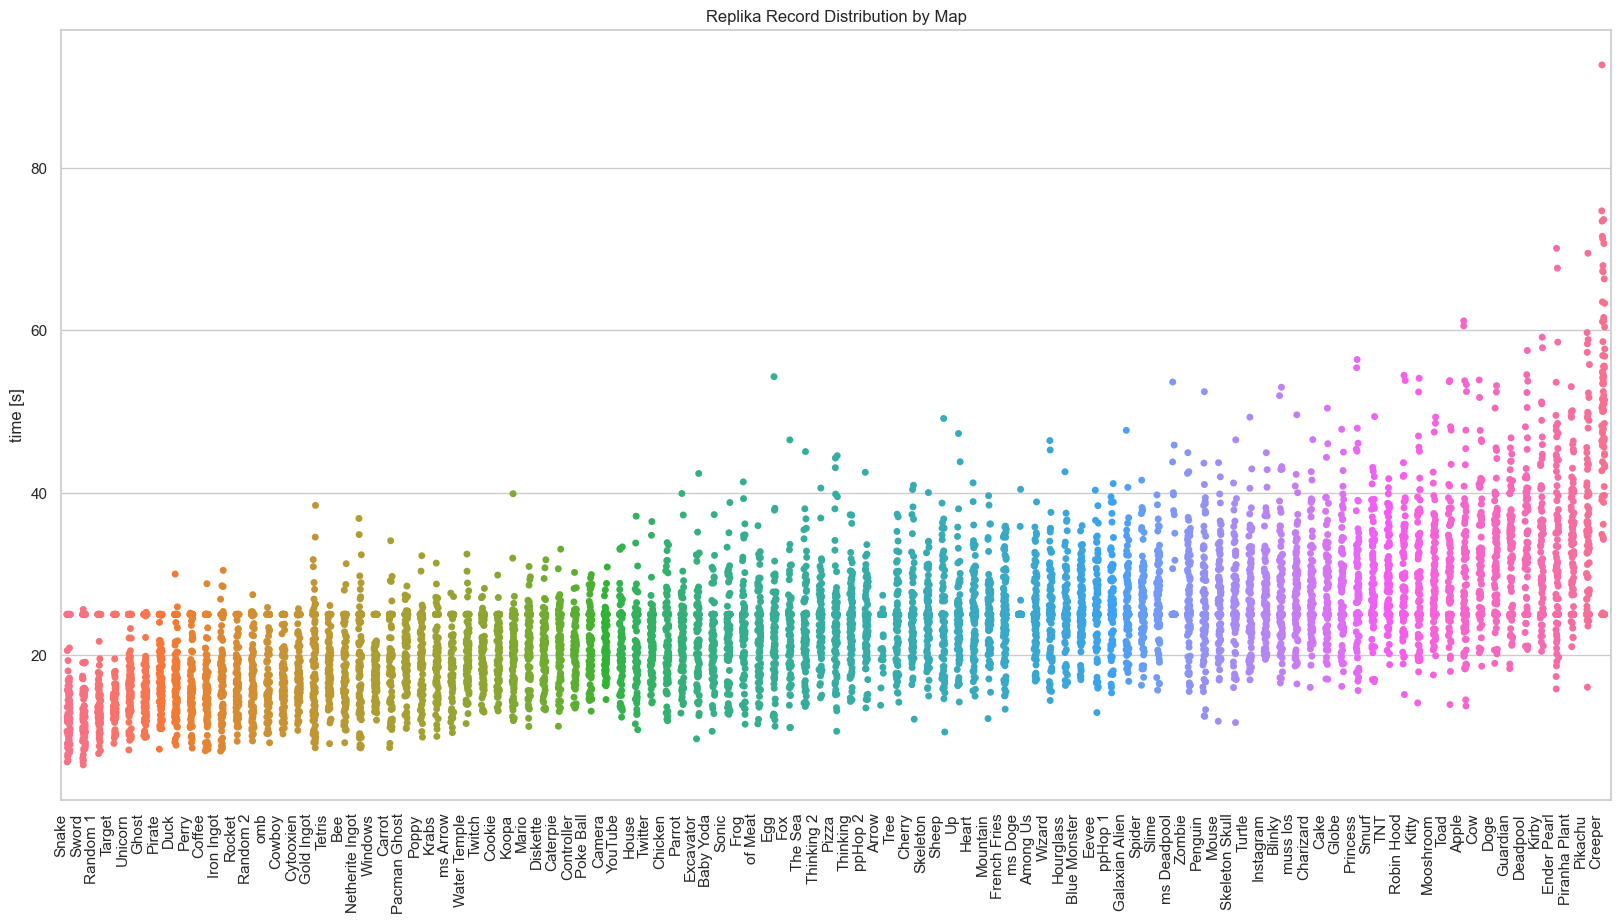

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Replika")

# Drop columns "ms Cow" and "ms Sonic"
data = data.drop(columns=["ms Cow", "ms Sonic", 'Sum'])

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.stripplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.title("Replika Record Distribution by Map")
plt.ylabel("time [s]")
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_18248\2307575918.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



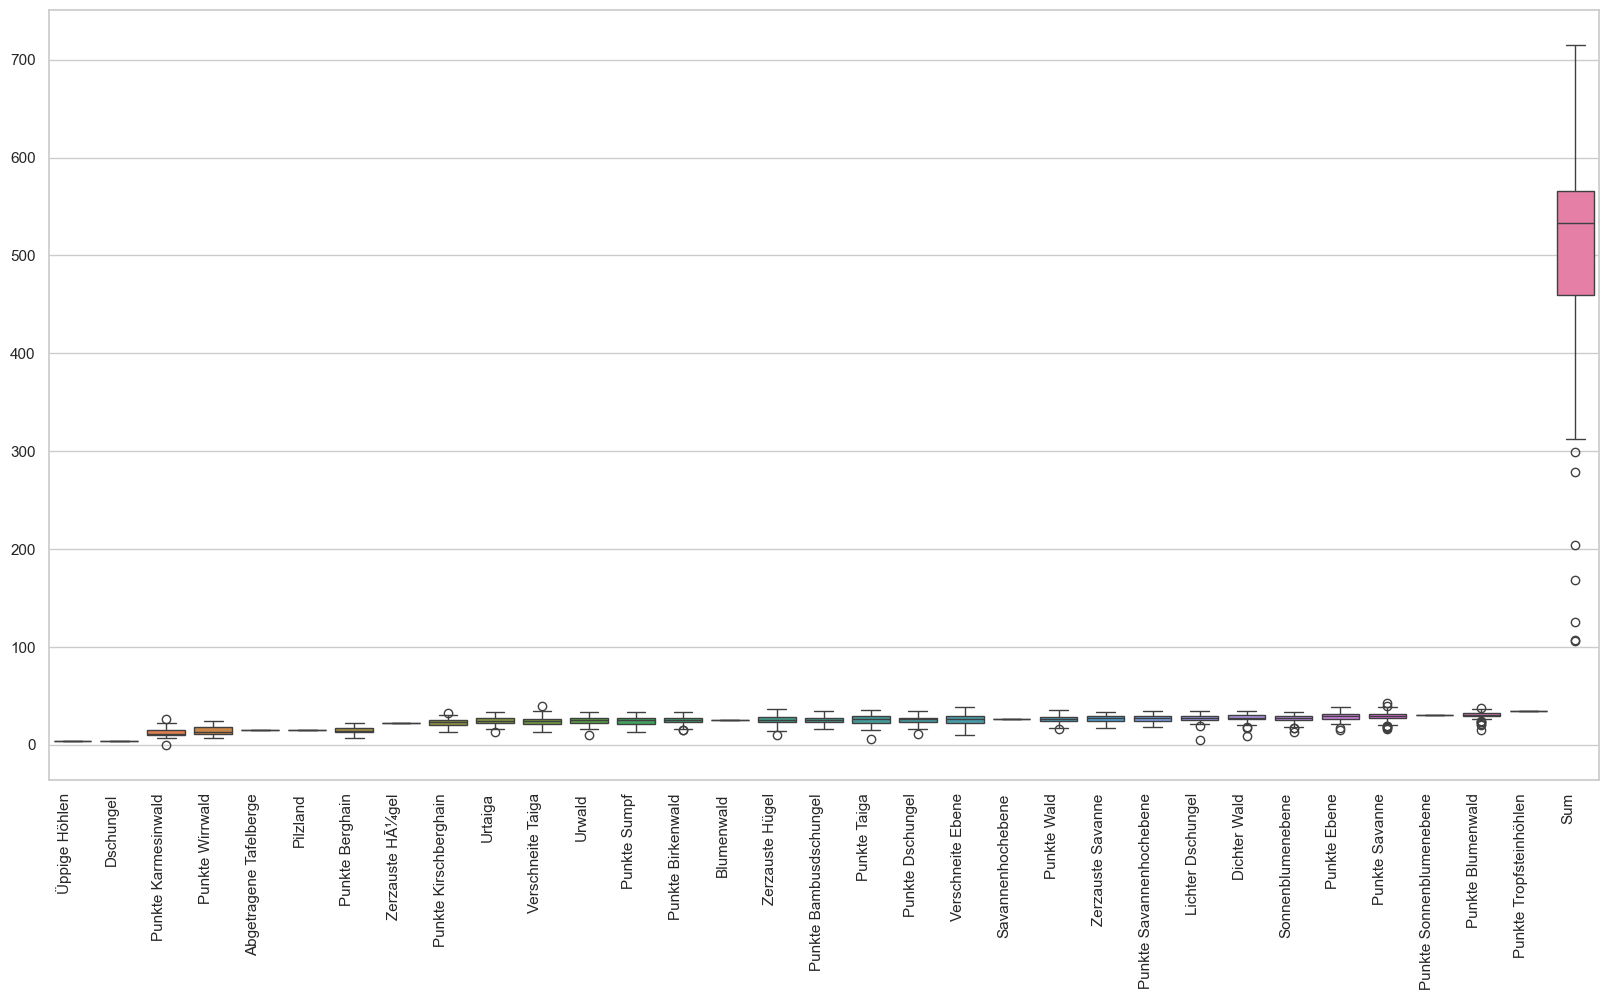

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Sammelwahn")

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.boxplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()


In [43]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Replika")

# Exclude the first column (assuming it's the column you don't want to include)
df_to_html = df.iloc[:, 1:]

# Calculate the offset for centering the data points
num_columns = len(df_to_html.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df_to_html.columns):
    x_values = [i + offset] * len(df_to_html[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df_to_html[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df_to_html.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Replika Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/repl_swarm_plot.html")


In [44]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Sammelwahn")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Sammelwahn Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Points"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/sammel_swarm_plot.html")

In [45]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Pferderennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Pferderennen Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/pferd_swarm_plot.html")

In [46]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Wettrennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Wettrennen Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/wettr_swarm_plot.html")

In [47]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Drachenflucht")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Drachenflucht Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/drache_swarm_plot.html")

In [48]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Lasertag")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Lasertag Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Kills"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/laser_swarm_plot.html")

In [49]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Elytrarennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Elytrarennen Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/elytr_swarm_plot.html")

In [50]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Jump and Run")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="JnR Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/jump_swarm_plot.html")

In [51]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Freier Fall")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Dropper Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/fall_swarm_plot.html")

In [52]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Schießstand")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Schießstand Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Points"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/bow_swarm_plot.html")

In [53]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Paintball")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Paintball Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Kills"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/paint_swarm_plot.html")

In [54]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Kletter-König")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="KOTH Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]", range=[30, 65]),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/koth_swarm_plot.html")